# Class 5: Dimension Reduction, Topic Modeling

For this class we will use the American Stories dataset from Melissa Dell. 

Need to install additional packages. Run this on the terminal or on Anaconda Prompt. Remember to activate the environment.
```
conda activate text_as_data
conda install conda-forge::datasets
conda install conda-forge::pyldavis
```
To download the dataset, follow the instructions AmericanStories page on Hugging Face.


In [105]:
import pandas as pd
import re
import matplotlib.pyplot as plt
import numpy as np


In [106]:
from datasets import load_dataset
#  Download data for the year 1958 
dataset = load_dataset("dell-research-harvard/AmericanStories",
                       "subset_years",
                       year_list=["1958"],
                       trust_remote_code=True
                       )

In [107]:
print(dataset)


DatasetDict({
    1958: Dataset({
        features: ['article_id', 'newspaper_name', 'edition', 'date', 'page', 'headline', 'byline', 'article'],
        num_rows: 98688
    })
})


The object `dataset` that we just created is a `DatasetDict`, which is a class from the *Hugging Face* datasets package. This library is specifically designed to offer ways to handle _large_ datasets that you would not be able to load on your laptop's RAM memory. We may cover some of these topics later in the course, but if you are curious you can find more information directly on [Hugging Face](https://huggingface.co/learn/nlp-course/chapter5/1?fw=pt).

For simplicity, let's convert it to Pandas and obtain a pandas DataFrame. We can then measure the size of the dataframe in terms of RAM memory usage.

In [108]:
df = dataset['1958'].to_pandas()
print(type(df))

<class 'pandas.core.frame.DataFrame'>


In [109]:
# Calculate memory usage
total_memory_bytes = df.memory_usage(deep=True).sum()
total_memory_megabytes = total_memory_bytes / (1024 ** 2)

print(f"Total memory usage of the DataFrame: {total_memory_megabytes:.2f} MB")

Total memory usage of the DataFrame: 121.74 MB


In [110]:
df.head()

,article_id,newspaper_name,edition,date,page,headline,byline,article
0,2_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,You Con Bleach\nOld Furniture,,Sometimes when you take\non the old finish fro...
1,3_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,SeuIonts\n\n\nDescribed,,"New types Of coverings f0r\nfloors, walls, cei..."
2,4_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,Dwellings Approved\nIn Prince Georges,,Recent building permits is\nsued By Prince Geo...
3,5_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,,,"Edward Walters, Bi2f b3rd ave,\nCamp springs o..."
4,7_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,SILVER SPRING\n\nsloo Wire Avenue,,"Lovely, large brick home on beau.\niaininr. Il..."


In [111]:
len(df)

98688

In [112]:
df.head(10)

,article_id,newspaper_name,edition,date,page,headline,byline,article
0,2_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,You Con Bleach\nOld Furniture,,Sometimes when you take\non the old finish fro...
1,3_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,SeuIonts\n\n\nDescribed,,"New types Of coverings f0r\nfloors, walls, cei..."
2,4_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,Dwellings Approved\nIn Prince Georges,,Recent building permits is\nsued By Prince Geo...
3,5_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,,,"Edward Walters, Bi2f b3rd ave,\nCamp springs o..."
4,7_1958-07-12_p36_sn83045462_00280608804_195807...,Evening star.,01,1958-07-12,p36,SILVER SPRING\n\nsloo Wire Avenue,,"Lovely, large brick home on beau.\niaininr. Il..."
5,12_1958-07-12_p36_sn83045462_00280608804_19580...,Evening star.,01,1958-07-12,p36,"MONTGOMERY ESTATE.\n\nBeltsviIIe, Near NSA\nS1...",,3ioioJV-tHS iSIWS\n\n\nMore house for the mone...
6,13_1958-07-12_p36_sn83045462_00280608804_19580...,Evening star.,01,1958-07-12,p36,. ApELPHI HEIGHTS\n\n930s AdeIphi Road,,NeW brick Rambler. Unusually\nattractive moder...
7,14_1958-07-12_p36_sn83045462_00280608804_19580...,Evening star.,01,1958-07-12,p36,SILVER SPRING\n\noS0S Adelphi Road,,Very attractive Cape COD brick.\nJust 2 years ...
8,15_1958-07-12_p36_sn83045462_00280608804_19580...,Evening star.,01,1958-07-12,p36,HUGH Z. PECK\n\n\nOFFERS\nSELECT HOMES\n\nOPEN...,,IluI0 FuFHGW UFIVl\nNe this sparkllng 3 bedroo...
9,22_1958-07-12_p36_sn83045462_00280608804_19580...,Evening star.,01,1958-07-12,p36,NEW HAMPSHIRE\nGARDENS\n\nsllo Hammond Ave-.,,Oily Hummono ave.\n\n\nModern brick and stone ...


In [113]:
df.loc[0, "article"]


'Sometimes when you take\non the old finish from a piece\nIof furniture with paint and\nvarnish remover. the wood Il\nstill dark from the original\nstain.\n\n\nII you want the wood 10\nbe still lighter. so it viii har-\nmonize with newly bought fur\nniture, use a bleach which you\ncan obtain from your paint\ndealer.'

In [114]:
df.loc[10, "article"]

'I02l0 Green Forest D..\n~ 4 Bedrooms, ; Baths\n\'a9 New Split Level Home\nLiving room with fireplace. dininE\n! room, heautifHl kitchens 26-ft.\nrecreation room, 2-ear garage,\nprestige location. Terms or trade.\nDir: Ont Rep Hampshire Are. to\nForest Dr., right to Peck\'s Open"\nSt0R.'

In [115]:
df.loc[68547, "article"]

"/ After moving to Washing\nton, she left the concert field\nand. devoted herself increas-\ningly to teaching. 1t was here\nthat she served as a voice\ncoach to Lindsey Bergen.\n\n\nMrs. Couth was an early sup\nporter of efforts to establish\nthe National Symphony Or\nchestra. She also had been\nmusical director Of the Friday\nMorning Music Club and was\npast president of the Women's\nCity Club.\n\n\nAfter her husbands death in\n1913, she made her home with\nDR.. Doris M. Cochran, a cura-\ntor at the National Museum.\n\n\nShe is survived by a brother\nRobert j. liant of Hudson,\nOhio.\n\n\nA memorial service will be\nconducted at 10 am. tomorrow\nin the Gasch funeral home,\n1879 Baltimore avenue, Hyatts-\nvile. Entombment will be in\nCleveland."

In [116]:
df.loc[5756, "article"]

"ALTA VISTA--3-bedrm., 1Ja-bath\nbrick Colonial, on large attractive\ntfeed lot featuring separate liv-\ning room, dinine rnl., modem\nkitchen. lovely paneled recrea,\nton room, full basement and ga\nrage. Priced At only S22,550. Car\nbe bought FLA with low. low\ndown payment. EN- 2-S206. DIS\nTRICT MARYLAND REALTY\nINC Ewes. OIL. 4-3196.\n\n\nAMER. UNIV, WEsTGATE = Ar\nAlbert Walker home, in the most\nexclusive community, Bfl;. Colo\nNAL with liy. rrl., sep. din. rm.,\nkit, bedrooms, :, baths, full\nhsmt, scr. pch., att. gar. Priced\nfor immed, sale u lower 20s\n2-7006: ewes. OIL. 6-4592.\n\n\nASHTON AREA : Country homes\nbuilding sites and farms. ASHTON\nREALTY CO., WA. 4-9S1l.\n\n\nBATTERY PARK = owner hai\nbought another home, must SELL\nBrick home with bedrooms anC\n. baths: bedroom and full BATH\non trst floor; large screened pch\nLot 70x160. EDW. II, JONES a\nCO, INC. WO. $4,000. 9 til 8.\nBEIHESDA-3-bedroom brick Co.\nlonial; powder room on 1St floor\nmodern kit, sep. din. rm.,

Notice the specificities of the text, with errors coming from OCR and other items due to the use of organizing text in short columns.

In [117]:
df['article'] = df['article'].str.replace('-\n', '').str.replace('\n', ' ')

In [118]:
df.loc[0, "article"]

'Sometimes when you take on the old finish from a piece Iof furniture with paint and varnish remover. the wood Il still dark from the original stain.   II you want the wood 10 be still lighter. so it viii harmonize with newly bought fur niture, use a bleach which you can obtain from your paint dealer.'

https://radimrehurek.com/gensim/parsing/preprocessing.html

In [119]:
from gensim.parsing.preprocessing import preprocess_string
preprocess_string(df.loc[0, "article"])


['old',
 'finish',
 'piec',
 'iof',
 'furnitur',
 'paint',
 'varnish',
 'remov',
 'wood',
 'dark',
 'origin',
 'stain',
 'want',
 'wood',
 'lighter',
 'viii',
 'harmon',
 'newli',
 'bought',
 'fur',
 'nitur',
 'us',
 'bleach',
 'obtain',
 'paint',
 'dealer']

In [120]:
df['tokens'] = df['article'].apply(preprocess_string)


In [121]:
from collections import Counter

counts = Counter(df.loc[0,'tokens'])
for i in range(1, len(df)):
    counts += Counter(df.loc[i,'tokens'])

In [122]:
len(counts)

251560

In [123]:
counts.most_common(50)

[('mr', 99203),
 ('year', 34225),
 ('new', 32124),
 ('state', 29086),
 ('school', 28273),
 ('dai', 28130),
 ('said', 27303),
 ('home', 24432),
 ('servic', 19317),
 ('church', 18432),
 ('time', 18281),
 ('week', 18054),
 ('sundai', 17834),
 ('meet', 16459),
 ('ing', 15457),
 ('counti', 14853),
 ('presid', 13750),
 ('member', 13392),
 ('hous', 13125),
 ('miss', 12837),
 ('son', 12418),
 ('work', 12336),
 ('john', 12240),
 ('held', 11997),
 ('high', 11883),
 ('sale', 11737),
 ('club', 11413),
 ('nation', 11283),
 ('william', 11044),
 ('offic', 10920),
 ('good', 10898),
 ('unit', 10663),
 ('citi', 10583),
 ('even', 10177),
 ('program', 10120),
 ('present', 10024),
 ('guest', 9718),
 ('famili', 9676),
 ('man', 9566),
 ('lot', 9565),
 ('street', 9502),
 ('milford', 9493),
 ('area', 9459),
 ('report', 9338),
 ('plan', 9335),
 ('washington', 9305),
 ('public', 9107),
 ('district', 9025),
 ('room', 9002),
 ('old', 8948)]

In [124]:
counts.most_common()[::-1][:50]

[('georc', 1),
 ('oovcr', 1),
 ('plainsfield', 1),
 ('siralso', 1),
 ('necmsn', 1),
 ('hocpit', 1),
 ('nanticko', 1),
 ('natinnt', 1),
 ('fetrowa', 1),
 ('rejerom', 1),
 ('tosnew', 1),
 ('thmai', 1),
 ('kiwaini', 1),
 ('itheta', 1),
 ('roiier', 1),
 ('sneao', 1),
 ('ohnstad', 1),
 ('semet', 1),
 ('cyld', 1),
 ('cancili', 1),
 ('speakmai', 1),
 ('licid', 1),
 ('ctoper', 1),
 ('fruitt', 1),
 ('spohsor', 1),
 ('deeh', 1),
 ('tlckaro', 1),
 ('ltingl', 1),
 ('clarnnc', 1),
 ('viaistud', 1),
 ('gereontolog', 1),
 ('earnos', 1),
 ('draction', 1),
 ('hcspi', 1),
 ('paneok', 1),
 ('okleosak', 1),
 ('einer', 1),
 ('walteria', 1),
 ('gorl', 1),
 ('kunayak', 1),
 ('macnamani', 1),
 ('ghou', 1),
 ('throa', 1),
 ('aoport', 1),
 ('koa', 1),
 ('ournod', 1),
 ('jeasen', 1),
 ('waor', 1),
 ('cenuri', 1),
 ('badmen', 1)]

## Dimension Reduction

Here we will reduce the dimensionality of the data. Dimensionality reduction can be used in several contexts where the excessive presence of noise can be detrimental. Clustering is one example, but it can also be used in prediction/classification tasks, as well as to create new variables to be used directly in the analysis.
 
If we look at the documentation from scikit-learn for Principal Component Analysis we find

https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

You will notice that the class does not support sparse input. We will therefore need to use another class: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.TruncatedSVD.html#sklearn.decomposition.TruncatedSVD

See also the use guide by Scikit-learn
https://scikit-learn.org/stable/modules/decomposition.html#truncated-singular-value-decomposition-and-latent-semantic-analysis

In [125]:
#Here we will use the TF-IDF vectorizer. See Problem Set 2 for more details.
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(tokenizer=None,
                        max_features=10000,
                        use_idf=True,
                        lowercase=False,
                        ngram_range=(1,2),
                        max_df=0.3,
                        min_df=0.001,
                        sublinear_tf=True #Recommended in the TruncatedSVD guide
                        )

X = tfidf.fit_transform(df['tokens'].apply(lambda tokens: " ".join(tokens)))

Notice that we are being quite restrictive by limiting to a min_df=0.001. We need the token to appear in at least approximately 100 documents to be included. This leads us from 251560 tokens to 8364 (including bigrams).

In [126]:
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=50, algorithm='randomized')
X_svd = svd.fit_transform(X)
explained_variance_ratio = svd.explained_variance_ratio_

In [127]:
print(explained_variance_ratio)

[0.0032354  0.0063494  0.00490084 0.00397238 0.00377808 0.00355959
 0.00341778 0.00291036 0.00278619 0.00255816 0.00226262 0.0021633
 0.00205944 0.00203382 0.00195025 0.00185088 0.00180197 0.00177597
 0.00173392 0.00165777 0.00163641 0.00159215 0.00158059 0.00156034
 0.00151307 0.00148887 0.00144975 0.00141185 0.00139483 0.00136448
 0.00132616 0.00132286 0.00130818 0.00129083 0.00125828 0.00124614
 0.00122271 0.00121192 0.00119286 0.00115873 0.00113765 0.00112604
 0.00110685 0.00108587 0.0010779  0.00106217 0.00103814 0.00103136
 0.00102228 0.00101817]


In [128]:
svd = TruncatedSVD(n_components=2000, algorithm='randomized') #Consider a smaller number
X_svd = svd.fit_transform(X)
explained_variance_ratio = svd.explained_variance_ratio_

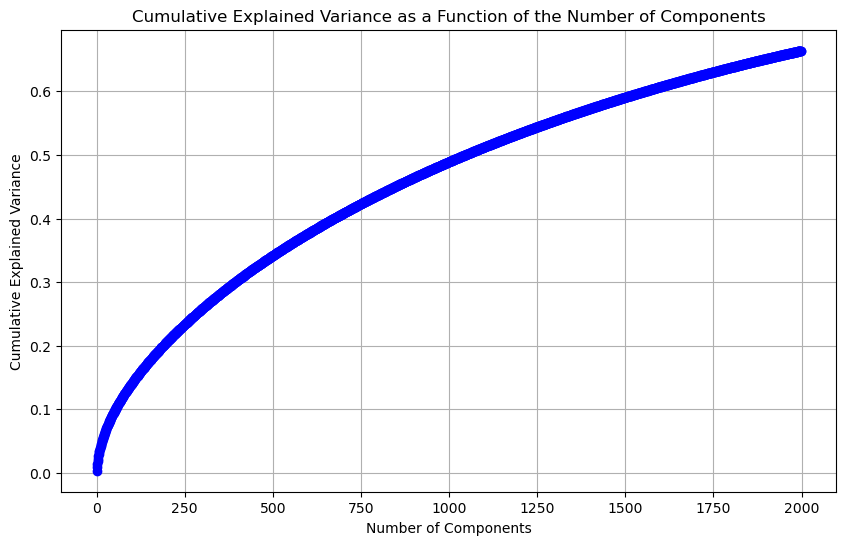

In [129]:
# Calculate the cumulative sum of explained variance ratios
cumulative_explained_variance = np.cumsum(explained_variance_ratio)

# Create the plot
plt.figure(figsize=(10, 6))
plt.plot(cumulative_explained_variance, marker='o', linestyle='-', color='b')

# Add title and labels
plt.title('Cumulative Explained Variance as a Function of the Number of Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')

plt.grid(True)
plt.show()

In [130]:
cumulative_explained_variance[-1]

0.6639475066482898

In [131]:
svd = TruncatedSVD(n_components=3, algorithm='randomized')
svd.fit(X)

# Loadings for the first component
component_1_loadings = svd.components_[1]

# Assuming you have feature names from CountVectorizer
feature_names = tfidf.get_feature_names_out()
high_weight_features = sorted(zip(feature_names, component_1_loadings), key=lambda x: abs(x[1]), reverse=True)

for feature, loading in high_weight_features[:20]:  # Adjust the slice for more or fewer features
    print(f"{feature}: {loading}")

mr: 0.3890011042774671
sundai: 0.20041775221060984
church: 0.164743907069429
said: -0.1261998897923721
daughter: 0.12279847692803962
rev: 0.1170933682055072
state: -0.10827702405470714
son: 0.10695376917398638
guest: 0.10639399098057747
even: 0.10193727692062003
miss: 0.09853963145611044
worship: 0.092926347916779
servic: 0.09150529853620783
home: 0.0845962411416884
sale: -0.08192578438638945
sundai school: 0.08083980310584656
spent: 0.07834608110873355
pastor: 0.07722474708488192
saturdai: 0.07318221095475536
funer: 0.07190031794033434


In [132]:
# Loadings for the first component
component_1_loadings = svd.components_[2]

# Assuming you have feature names from CountVectorizer
feature_names = tfidf.get_feature_names_out()
high_weight_features = sorted(zip(feature_names, component_1_loadings), key=lambda x: abs(x[1]), reverse=True)

for feature, loading in high_weight_features[:20]:  # Adjust the slice for more or fewer features
    print(f"{feature}: {loading}")

bath: 0.2489962245032689
sale: 0.22707711568768277
phone: 0.21859392162295116
bedrm: 0.19323295681840005
room: 0.18532358535447935
lot: 0.14868231612992386
brick: 0.1426451585254114
milford: 0.1398908374561819
state: -0.11943600143817075
bedroom: 0.117891270655742
price: 0.1159399906698885
kit: 0.11496845922700506
home: 0.11157729332370146
rent: 0.10538048331937828
rambler: 0.10517210333886032
bsmt: 0.10284188632999527
din: 0.09988851187091327
porch: 0.09982914352876196
larg: 0.09203625858348531
rec: 0.09122463315097619


### Latent Dirichlet Allocation

In [133]:
from gensim.corpora import Dictionary
from gensim.models.ldamodel import LdaModel
import re
# Your documents' token lists
texts = df['tokens'].tolist()

# Create a dictionary representation of the documents
dictionary = Dictionary(texts)

# Filter out extremes to limit the number of features
dictionary.filter_extremes(no_below=0.001, no_above=0.90, keep_n=10000)


dictionary.compactify()

# Convert document into a bag of word, following gensim package
corpus = [dictionary.doc2bow(text) for text in texts]

In [134]:
num_topics = 8
passes = 15

temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                     passes=passes, eval_every=None)

In [135]:
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.016*"room" + 0.014*"bath" + 0.013*"phone" + 0.013*"home" + 0.013*"lot" + 0.011*"hous" + 0.011*"av" + 0.011*"bedrm" + 0.011*"sale" + 0.009*"acr"')
(1, '0.027*"school" + 0.015*"church" + 0.014*"meet" + 0.012*"servic" + 0.011*"member" + 0.010*"sundai" + 0.009*"club" + 0.008*"held" + 0.008*"presid" + 0.007*"year"')
(2, '0.016*"state" + 0.010*"year" + 0.010*"said" + 0.007*"unit" + 0.006*"new" + 0.006*"nation" + 0.005*"presid" + 0.004*"senat" + 0.004*"govern" + 0.004*"work"')
(3, '0.009*"year" + 0.008*"time" + 0.008*"new" + 0.007*"said" + 0.007*"dai" + 0.005*"like" + 0.005*"old" + 0.004*"man" + 0.004*"ing" + 0.004*"good"')
(4, '0.026*"counti" + 0.019*"dai" + 0.018*"said" + 0.013*"court" + 0.012*"district" + 0.010*"land" + 0.010*"state" + 0.010*"sale" + 0.009*"offic" + 0.009*"street"')
(5, '0.103*"mr" + 0.013*"home" + 0.011*"son" + 0.010*"miss" + 0.010*"daughter" + 0.009*"sundai" + 0.009*"guest" + 0.008*"william" + 0.008*"john" + 0.007*"week"')
(6, '0.010*"new" + 0.009*"price" + 0.008*

In [136]:
import pyLDAvis.gensim_models as gensimvis
import pyLDAvis

# Prepare the visualization
pyLDAvis.enable_notebook()
vis = gensimvis.prepare(lda_model, corpus, dictionary)

# Display the visualization
pyLDAvis.display(vis)

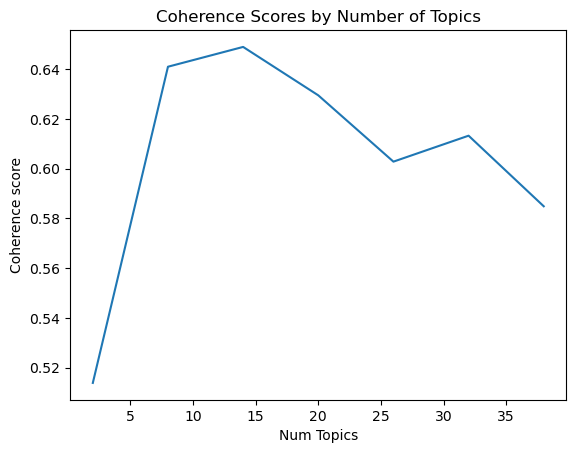

Num Topics = 2, Coherence Value = 0.5139
Num Topics = 8, Coherence Value = 0.6409
Num Topics = 14, Coherence Value = 0.6489
Num Topics = 20, Coherence Value = 0.6294
Num Topics = 26, Coherence Value = 0.6028
Num Topics = 32, Coherence Value = 0.6132
Num Topics = 38, Coherence Value = 0.5849


In [137]:
from gensim.models import CoherenceModel, LdaModel
import matplotlib.pyplot as plt
import numpy as np

def compute_coherence_values(dictionary, corpus, texts, start, limit, step):
    coherence_values = []
    for num_topics in range(start, limit + 1, step):
        # Create a new LDA model for each number of topics
        id2word = dictionary.id2token

        model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                         passes=passes, eval_every=None)
        # Compute the coherence score for the model
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return coherence_values

# Parameters for the coherence computation
start, limit, step = 2, 40, 6

# Ensure your 'texts', 'dictionary', and 'corpus' are correctly prepared before this step
coherence_values = compute_coherence_values(dictionary, corpus, texts, start, limit, step)

# Plotting the coherence scores
x = range(start, limit + 1, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.title("Coherence Scores by Number of Topics")
plt.show()

# Printing the coherence scores for each number of topics
for num_topics, coherence_value in zip(x, coherence_values):
    print(f"Num Topics = {num_topics}, Coherence Value = {round(coherence_value, 4)}")

In [138]:
num_topics = 20
passes = 15

temp = dictionary[0]  # This is only to "load" the dictionary
id2word = dictionary.id2token

lda_model = LdaModel(corpus=corpus, id2word=id2word, num_topics=num_topics,
                     passes=passes, eval_every=None)
topics = lda_model.print_topics()
for topic in topics:
    print(topic)

(0, '0.029*"new" + 0.028*"york" + 0.023*"citi" + 0.018*"san" + 0.017*"spring" + 0.016*"chicago" + 0.014*"lo" + 0.013*"silver" + 0.013*"angel" + 0.012*"loui"')
(1, '0.028*"meet" + 0.023*"member" + 0.021*"club" + 0.020*"presid" + 0.016*"held" + 0.010*"year" + 0.010*"offic" + 0.010*"program" + 0.010*"chairman" + 0.009*"present"')
(2, '0.043*"alaska" + 0.025*"state" + 0.024*"citi" + 0.019*"offic" + 0.015*"highwai" + 0.013*"depart" + 0.012*"build" + 0.012*"bid" + 0.011*"nome" + 0.011*"road"')
(3, '0.046*"sundai" + 0.041*"church" + 0.021*"even" + 0.021*"servic" + 0.017*"dai" + 0.017*"visit" + 0.017*"week" + 0.016*"rev" + 0.015*"home" + 0.015*"school"')
(4, '0.026*"home" + 0.022*"funer" + 0.020*"juli" + 0.017*"servic" + 0.014*"friend" + 0.013*"wife" + 0.013*"year" + 0.012*"di" + 0.012*"held" + 0.012*"brother"')
(5, '0.033*"sale" + 0.028*"land" + 0.026*"lot" + 0.024*"record" + 0.016*"said" + 0.016*"properti" + 0.016*"feet" + 0.015*"purchas" + 0.014*"trust" + 0.013*"dai"')
(6, '0.030*"said" + 0

In [139]:
document_topics = lda_model.get_document_topics(corpus[68547])

for topic_id, topic_proportion in document_topics:
    print(f"Topic {topic_id}: {topic_proportion * 100:.2f}%")

Topic 0: 8.91%
Topic 1: 16.31%
Topic 4: 31.02%
Topic 8: 3.92%
Topic 12: 6.72%
Topic 13: 5.90%
Topic 15: 2.66%
Topic 16: 13.74%
Topic 19: 9.83%


In [140]:
document_topics = lda_model.get_document_topics(corpus[5756])

for topic_id, topic_proportion in document_topics:
    print(f"Topic {topic_id}: {topic_proportion * 100:.2f}%")


Topic 4: 2.80%
Topic 5: 1.25%
Topic 6: 2.20%
Topic 8: 1.26%
Topic 10: 1.29%
Topic 13: 2.36%
Topic 14: 1.21%
Topic 15: 2.02%
Topic 17: 82.36%
Topic 18: 1.28%


In [141]:
num_topics = lda_model.num_topics
topic_coverage = np.zeros(num_topics)

for doc_bow in corpus:
    for topic_id, proportion in lda_model.get_document_topics(doc_bow, minimum_probability=0):
        topic_coverage[topic_id] += proportion

# Normalize by the number of documents to get the average coverage
topic_coverage /= len(corpus)

for topic_id, coverage in enumerate(topic_coverage):
    print(f"Topic {topic_id}: {coverage * 100:.2f}%")

Topic 0: 2.51%
Topic 1: 6.90%
Topic 2: 3.63%
Topic 3: 5.60%
Topic 4: 3.92%
Topic 5: 2.62%
Topic 6: 3.84%
Topic 7: 3.01%
Topic 8: 4.10%
Topic 9: 8.75%
Topic 10: 6.71%
Topic 11: 5.50%
Topic 12: 4.57%
Topic 13: 8.68%
Topic 14: 2.67%
Topic 15: 4.87%
Topic 16: 7.89%
Topic 17: 6.28%
Topic 18: 3.91%
Topic 19: 4.04%


We could be interested in studying how topics differ across newspaper or how they change over time. For this, we need to do something similar as what we have done above, but by group (newspaper or date, for example). 

In [142]:
article_counts_newspaper = df.groupby('newspaper_name').size()


In [143]:
newspapers = df['newspaper_name'].unique()

# Dictionary to hold indices for each newspaper
indices_by_newspaper = {}

for newspaper in newspapers:
    # Filter df for articles from the current newspaper
    articles_from_newspaper = df[df['newspaper_name'] == newspaper]

    # Store the indices of these articles
    indices_by_newspaper[newspaper] = articles_from_newspaper.index.tolist()


In [144]:
# Initialize a dictionary to hold topic coverage for each newspaper
topic_coverage_by_newspaper = {}

for newspaper, indices in indices_by_newspaper.items():
    # Initialize an array to hold topic coverage for the current newspaper
    topic_coverage = np.zeros(num_topics)

    # Calculate topic coverage for articles from the current newspaper
    for idx in indices:
        doc_bow = corpus[idx]  # Get the document corresponding to the current index
        doc_topics = lda_model.get_document_topics(doc_bow, minimum_probability=0)
        for topic_id, proportion in doc_topics:
            topic_coverage[topic_id] += proportion

    # Normalize by the number of documents from this newspaper to get the average coverage
    topic_coverage /= len(indices)

    # Store the topic coverage for the current newspaper
    topic_coverage_by_newspaper[newspaper] = topic_coverage



In [145]:
topics_by_newspaper = pd.DataFrame(topic_coverage_by_newspaper).transpose()

topics_by_newspaper.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000,36.000000
mean,0.024245,0.078411,0.030565,0.061865,0.043287,0.020508,0.037636,0.025190,0.044826,0.097319,0.051909,0.064385,0.047463,0.114660,0.029429,0.031164,0.087397,0.026693,0.033382,0.049666
std,0.011260,0.037965,0.024540,0.043579,0.036860,0.010217,0.015492,0.026530,0.021959,0.062441,0.037401,0.053981,0.045424,0.066827,0.012572,0.017636,0.052042,0.027776,0.019073,0.022389
min,0.003902,0.003200,0.005604,0.005913,0.011543,0.003200,0.012804,0.005897,0.013123,0.025394,0.008923,0.008425,0.014358,0.030438,0.010062,0.005089,0.012003,0.003493,0.010045,0.017665
25%,0.017833,0.054015,0.014217,0.037142,0.023334,0.012697,0.027341,0.014039,0.026336,0.065167,0.028717,0.028283,0.021796,0.071837,0.022960,0.018476,0.052997,0.009816,0.021472,0.034203
50%,0.023252,0.073044,0.022524,0.047824,0.030066,0.018444,0.035204,0.018357,0.042141,0.082754,0.045117,0.040239,0.034232,0.091470,0.026426,0.027067,0.075436,0.017261,0.027207,0.045860
75%,0.030143,0.094678,0.035077,0.077033,0.046021,0.026356,0.044252,0.026062,0.054498,0.095078,0.064918,0.090071,0.051981,0.132593,0.034294,0.039082,0.114635,0.028419,0.038572,0.063866
max,0.062946,0.177368,0.111833,0.189680,0.189093,0.040187,0.071202,0.159069,0.103542,0.344742,0.216357,0.224293,0.219793,0.320446,0.061177,0.079329,0.254144,0.131168,0.099032,0.119588


In [146]:
topics_by_newspaper.head(5)

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
Evening star.,0.032148,0.032176,0.017667,0.016362,0.066099,0.031661,0.039530,0.023095,0.053344,0.085165,0.062335,0.061745,0.048668,0.087617,0.026182,0.079329,0.041176,0.131168,0.037555,0.026979
The Nome nugget.,0.025340,0.053666,0.085465,0.040096,0.029863,0.017886,0.070261,0.037791,0.032452,0.088106,0.032465,0.095259,0.061708,0.085795,0.024869,0.026278,0.055887,0.011300,0.099032,0.026480
Minneapolis spokesman.,0.037887,0.058415,0.019980,0.059999,0.066202,0.017606,0.028563,0.019148,0.064656,0.062368,0.032850,0.112006,0.045248,0.146573,0.036221,0.025476,0.080568,0.029746,0.019123,0.037365
The people's voice.,0.008331,0.054131,0.024851,0.007613,0.011543,0.016446,0.029337,0.026506,0.015301,0.344742,0.020399,0.224293,0.035814,0.072492,0.010567,0.009991,0.017975,0.006459,0.021505,0.041703
The frontiersman.,0.020354,0.133197,0.111833,0.042573,0.022916,0.022570,0.025026,0.030892,0.057959,0.090339,0.066537,0.037862,0.016095,0.054345,0.036959,0.067952,0.058684,0.027976,0.030111,0.045821


Something similar to what we did above could be done using the author-topic model from Gensim. Here we would direclty modify the estimation process to take into consideration the author (in this case the newspaper). 

A tutorial on author-topic model is available here: https://github.com/piskvorky/gensim/blob/develop/docs/notebooks/atmodel_tutorial.ipynb